<a href="https://colab.research.google.com/github/drishtigulenia/pneumonia-prediction-cnn/blob/main/PneumoniaPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credits to Paul Mooney
https://www.kaggle.com/paultimothymooney for the dataset.

In [1]:
# importing google drive
from google.colab import drive

In [2]:
# getting contents of drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd

In [4]:
# providing path to train, test and validation folders which contains images
train_path = '/content/gdrive/MyDrive/Colab Notebooks/Datasets/chest_xray/train'
test_path = '/content/gdrive/MyDrive/Colab Notebooks/Datasets/chest_xray/train'
val_path = '/content/gdrive/MyDrive/Colab Notebooks/Datasets/chest_xray/val'
Img_size = [224,224]

In [5]:
import tensorflow as tf

In [6]:
# Input is used to instantiate keras tensor
# Dense is how much nodes/units you want in your 1 hidden layer
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
# inceptionv3 is one of keras applications which has pre-trained weights
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
# imagedatagenerator is used to transform images to a form which is acceptable by our model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# Sequential model is linear stack of layers given into its input. It is the simplest form of model
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
import numpy as np
# for regex
from glob import glob

In [7]:
# making sure if we are using a gpu that tf is able to identify correctly and we are enabling memory growth as well
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('NUM GPUs AVAILABLE ' , len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

NUM GPUs AVAILABLE  1


In [ ]:
# we would not be including top and bottom layers as we want to specify our own image size

model = InceptionV3(input_shape=Img_size+[3], weights='imagenet', include_top=False)

In [ ]:
#  we don't train the weights as i want to use already given weights in inceptionv3 by keras
for layer in model.layers:
  layer.trainable = False

In [ ]:
# number of classes would be equal to number of folders in the directory
folders = glob('/content/gdrive/MyDrive/Colab Notebooks/Datasets/chest_xray/train/*')
folders

['/content/gdrive/MyDrive/Colab Notebooks/Datasets/chest_xray/train/PNEUMONIA',
 '/content/gdrive/MyDrive/Colab Notebooks/Datasets/chest_xray/train/NORMAL']

In [ ]:
# flatten into 1D tensor before passing it to our output layer
x = Flatten()(model.output)

In [ ]:
# output layer
#  we can also use softmax activation function for multiple classes(more than 2 classes) with categorial_crossentropy as the loss func
predictions = Dense(len(folders), activation='sigmoid')(x)

# creating model object
model = Model(inputs=model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# compiling our model
# declaring cost and optimization functions
# we can use categorical_crossentropy if more than 2 classes are there along with softmax activation func
# A metric is a function that is used to judge the performance of your model.
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# whenever we train our model we need to put the data into a format that our model expects, model recieves the data when we call fit func so,
# we will put our images into the format of keras image generator
# preprocessing_func = it will do some preprocessing on our data which is acceptable by out inception_v3 model
train_batches = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
val_batches = ImageDataGenerator(rescale = 1./255)
test_batches = ImageDataGenerator(rescale = 1./255)

In [13]:
# This cell will return a directory iterator which will create batches of our data from the directories where our dataset resides and these batches of data 
# will be passed to our model using the fit function
train_batches = train_batches.flow_from_directory(train_path, target_size=(224,224), color_mode='rgb', batch_size=32, classes=['PNEUMONIA', 'NORMAL'])
val_batches = val_batches.flow_from_directory(val_path, target_size=(224,224), color_mode='rgb', batch_size=32, classes=['PNEUMONIA', 'NORMAL'])

# for our test batches we have specified it to be false parameter, to look our predictions in the form of confusion matrix we need to be able to access
# the unshuffled labels for our test set
test_batches = test_batches.flow_from_directory(test_path, target_size=(224,224), color_mode='rgb', batch_size=32, classes=['PNEUMONIA', 'NORMAL'], shuffle=False)

Found 5256 images belonging to 2 classes.


In [ ]:
# checking number of images we got in above cell are correct or not
assert train_batches.n == 5256
assert val_batches.n == 16
assert test_batches.n == 5256
assert train_batches.num_classes == val_batches.num_classes == test_batches.num_classes == 2

In [ ]:
# next returns the next item from the iterator, here it is giving for 1 batch i.e, batch_size = 32
imgs, labels = next(train_batches)

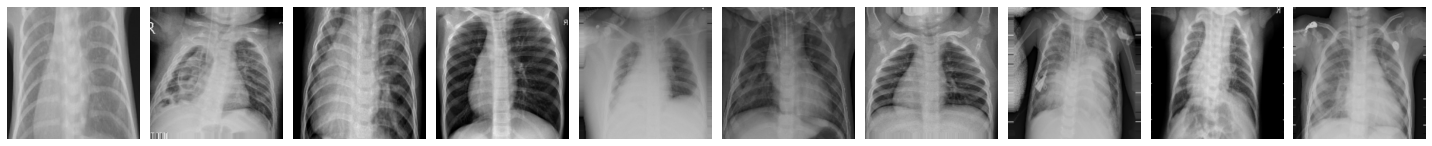

In [ ]:
# plotting images
import matplotlib.pyplot as plt

# the second arguement can be changed to how much images you want to see in 1 horizontal plane
# the below method to plot images is directly copied from tensorflow
fig, axes = plt.subplots(1,10,figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(imgs, axes):
  ax.imshow(img)
  ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# 1 batch labels - 32 labels
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
i = model.fit_generator(train_batches,
                        validation_data = val_batches,
                        epochs = 20,
                        steps_per_epoch= len(train_batches),
                        validation_steps=len(val_batches))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
165/165 [==============================] - 157s 856ms/step - loss: 0.2257 - accuracy: 0.9115 - val_loss: 0.4398 - val_accuracy: 0.8750
Epoch 2/20
165/165 [==============================] - 136s 821ms/step - loss: 0.1444 - accuracy: 0.9450 - val_loss: 0.5497 - val_accuracy: 0.8750
Epoch 3/20
165/165 [==============================] - 137s 832ms/step - loss: 0.1252 - accuracy: 0.9536 - val_loss: 0.4260 - val_accuracy: 0.8750
Epoch 4/20
165/165 [==============================] - 136s 824ms/step - loss: 0.1225 - accuracy: 0.9566 - val_loss: 0.4688 - val_accuracy: 0.8750
Epoch 5/20
165/165 [==============================] - 136s 822ms/step - loss: 0.1299 - accuracy: 0.9515 - val_loss: 0.8520 - val_accuracy: 0.7500
Epoch 6/20
165/165 [==============================] - 136s 823ms/step - loss: 0.0977 - accuracy: 0.9646 - val_loss: 0.6202 - val_accuracy: 0.8750
Epoch 7/20
165/165 [==============================] - 137s 830ms/step - loss: 0.1012 - accuracy: 0.9633 - val_loss: 0.5213 -

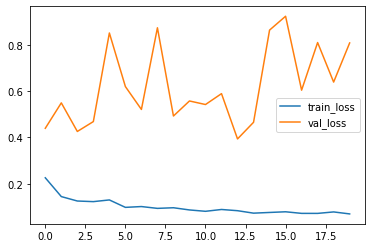

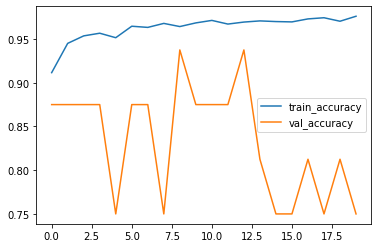

In [ ]:
# plotting the loss
plt.plot(i.history['loss'], label='train_loss')
plt.plot(i.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# plotting the accuracy
plt.plot(i.history['accuracy'], label='train_accuracy')
plt.plot(i.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
# since only 16 images are there in validation set it does not have a specific decreasing plot

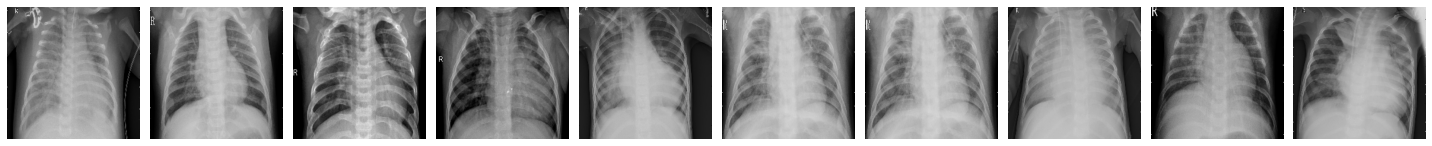

In [ ]:
# plotting test images
test_imgs, test_labels = next(test_batches)
fig, axes = plt.subplots(1,10,figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(test_imgs, axes):
  ax.imshow(img)
  ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
print(test_labels)
# since our test set is unshuffled it is only sjowing labels for 1st class

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
test_batches.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [9]:
import pickle
pickle.dump(model, open('/content/gdrive/MyDrive/Colab Notebooks/Projects/PneumoniaPrediction/pneumonia_model2_inceptionv3.pkl', 'wb'))

In [10]:
model = pickle.load(open('/content/gdrive/MyDrive/Colab Notebooks/Projects/PneumoniaPrediction/pneumonia_model2_inceptionv3.pkl', 'rb'))

In [14]:
predictions = model.predict(x=test_batches, verbose=0)

In [15]:
np.round(predictions)
predictions

array([[9.9998879e-01, 2.8719875e-05],
       [9.4118851e-01, 9.2745923e-02],
       [9.9498820e-01, 6.9063129e-03],
       ...,
       [3.2319781e-01, 6.4104724e-01],
       [6.3365521e-03, 9.9109954e-01],
       [2.2394991e-01, 8.4037954e-01]], dtype=float32)

In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [18]:
test_batches.class_indices

{'NORMAL': 1, 'PNEUMONIA': 0}

In [19]:
cm

array([[3820,   95],
       [  31, 1310]])

In [20]:
(3820+1310)/5256 *100

97.6027397260274

In [21]:
# accuracy = 97.6 